# **Heart Disease**

## Tabela de Conteúdo
1) Importação de bibliotecas + dataset
2) EDA (Análise Exploratória de Dados)
3) Pré-processamento de Dados
    - Limpeza de Dados
    - Normalização de Dados
    - Codificação de Dados
    - Engenharia de Features
    - Divisão de Dados
    - Aumento de Dados
4) Seleção do Modelo
    - Treinamento de Modelos (usando validação cruzada)
    - Comparação de Modelos (múltiplos algoritmos)
    - Otimização de Hiperparâmetros
    - Avaliação do Modelo
5) Salvamento do Melhor Modelo

## 1) Importação de bibliotecas e dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
import ydata_profiling as pp
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from mlxtend.classifier import StackingCVClassifier

In [2]:
data = pd.read_csv('./db/processed.cleveland.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


## 2) Análise Exploratória de Dados (EDA)

In [3]:
print(f"Dataset shape: {data.shape}")
print("\nData types:")
print(data.dtypes)

Dataset shape: (303, 14)

Data types:
age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca           object
thal         object
target        int64
dtype: object


In [4]:
print("\nMissing values:")
print(data.isnull().sum())

print("\nBasic statistics:")
print(data.describe())


Missing values:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Basic statistics:
              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.438944    0.679868    3.158416  131.689769  246.693069    0.148515   
std      9.038662    0.467299    0.960126   17.599748   51.776918    0.356198   
min     29.000000    0.000000    1.000000   94.000000  126.000000    0.000000   
25%     48.000000    0.000000    3.000000  120.000000  211.000000    0.000000   
50%     56.000000    1.000000    3.000000  130.000000  241.000000    0.000000   
75%     61.000000    1.000000    4.000000  140.000000  275.000000    0.000000   
max     77.000000    1.000000    4.000000  200.000000  564.000000    1.000000   

          restecg     tha

In [5]:
print("\nTarget variable distribution:")
print(data['target'].value_counts())
print(data['target'].value_counts(normalize=True).round(2))


Target variable distribution:
target
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64
target
0    0.54
1    0.18
2    0.12
3    0.12
4    0.04
Name: proportion, dtype: float64


In [6]:
data['target'] = data['target'].apply(lambda x: 0 if x == 0 else 1)
print(data['target'].value_counts())

target
0    164
1    139
Name: count, dtype: int64


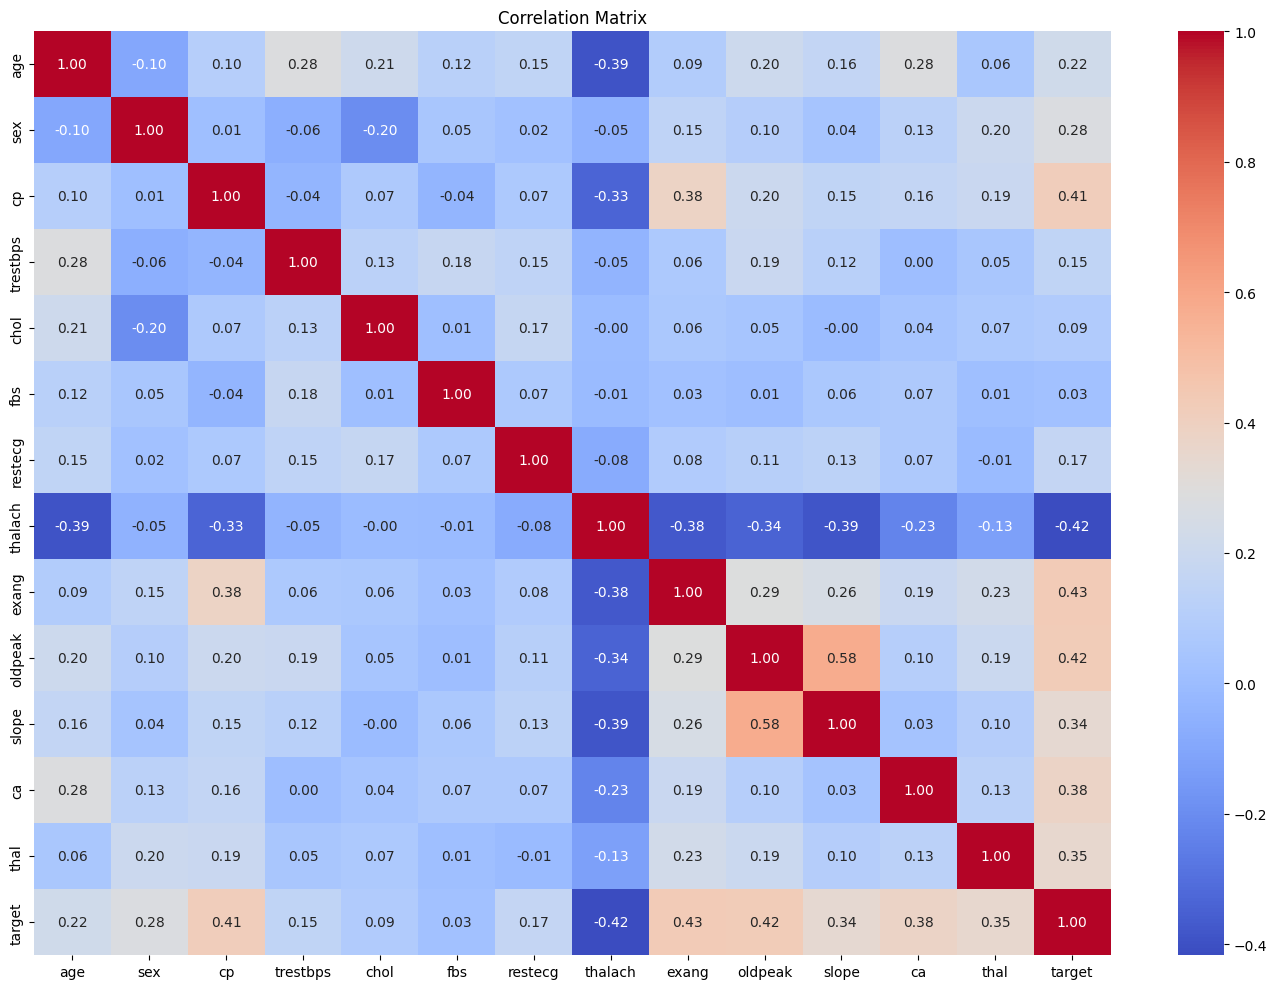

In [7]:
plt.figure(figsize=(14, 10))
correlation_matrix = data.apply(lambda x: pd.factorize(x)[0] if x.dtype == 'object' else x).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

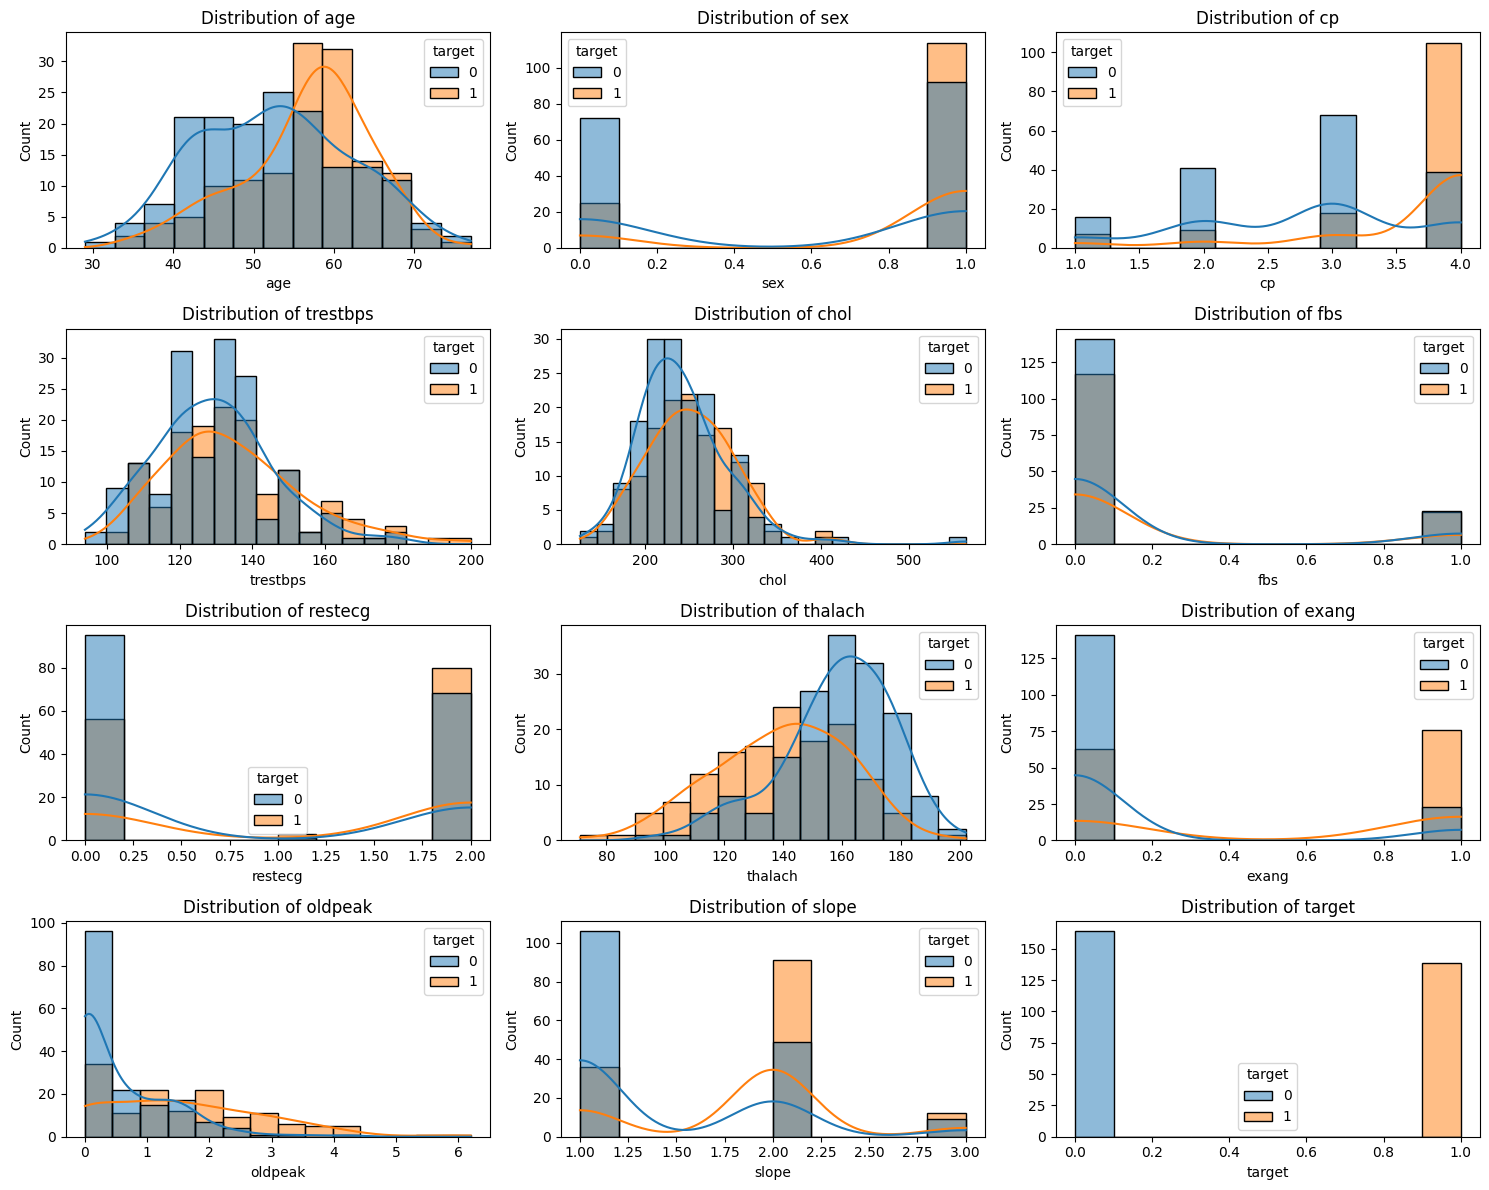

In [8]:
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(15, 12))
for i, feature in enumerate(numerical_features):
    plt.subplot(4, 3, i+1)
    sns.histplot(data=data, x=feature, hue='target', kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

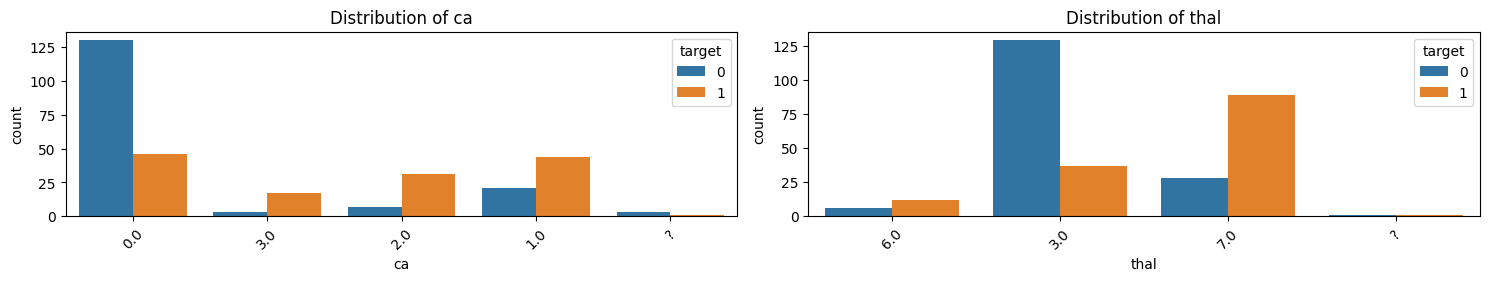

In [9]:
categorical_features = data.select_dtypes(include=['object']).columns.drop('target') if 'target' in data.select_dtypes(include=['object']).columns else data.select_dtypes(include=['object']).columns
plt.figure(figsize=(15, 10))
for i, feature in enumerate(categorical_features):
    plt.subplot(4, 2, i+1)
    sns.countplot(data=data, x=feature, hue='target')
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


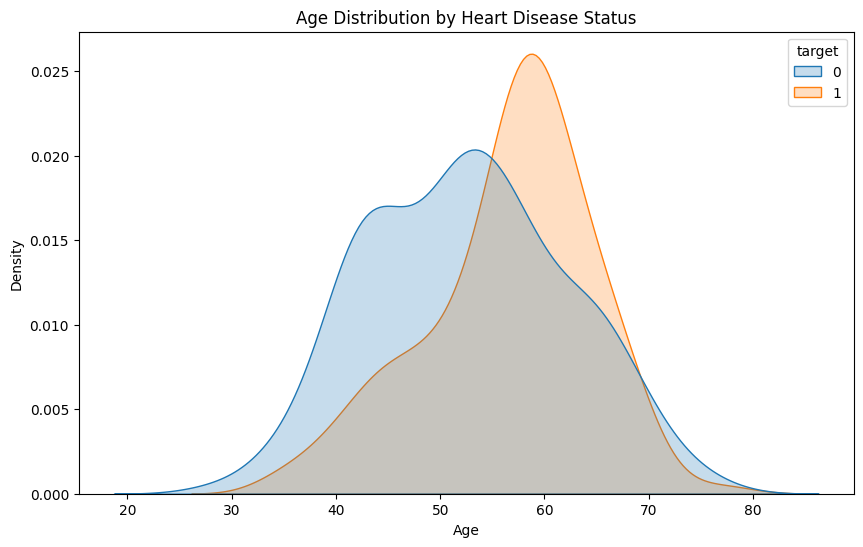

In [10]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, x='age', hue='target', fill=True)
plt.title('Age Distribution by Heart Disease Status')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

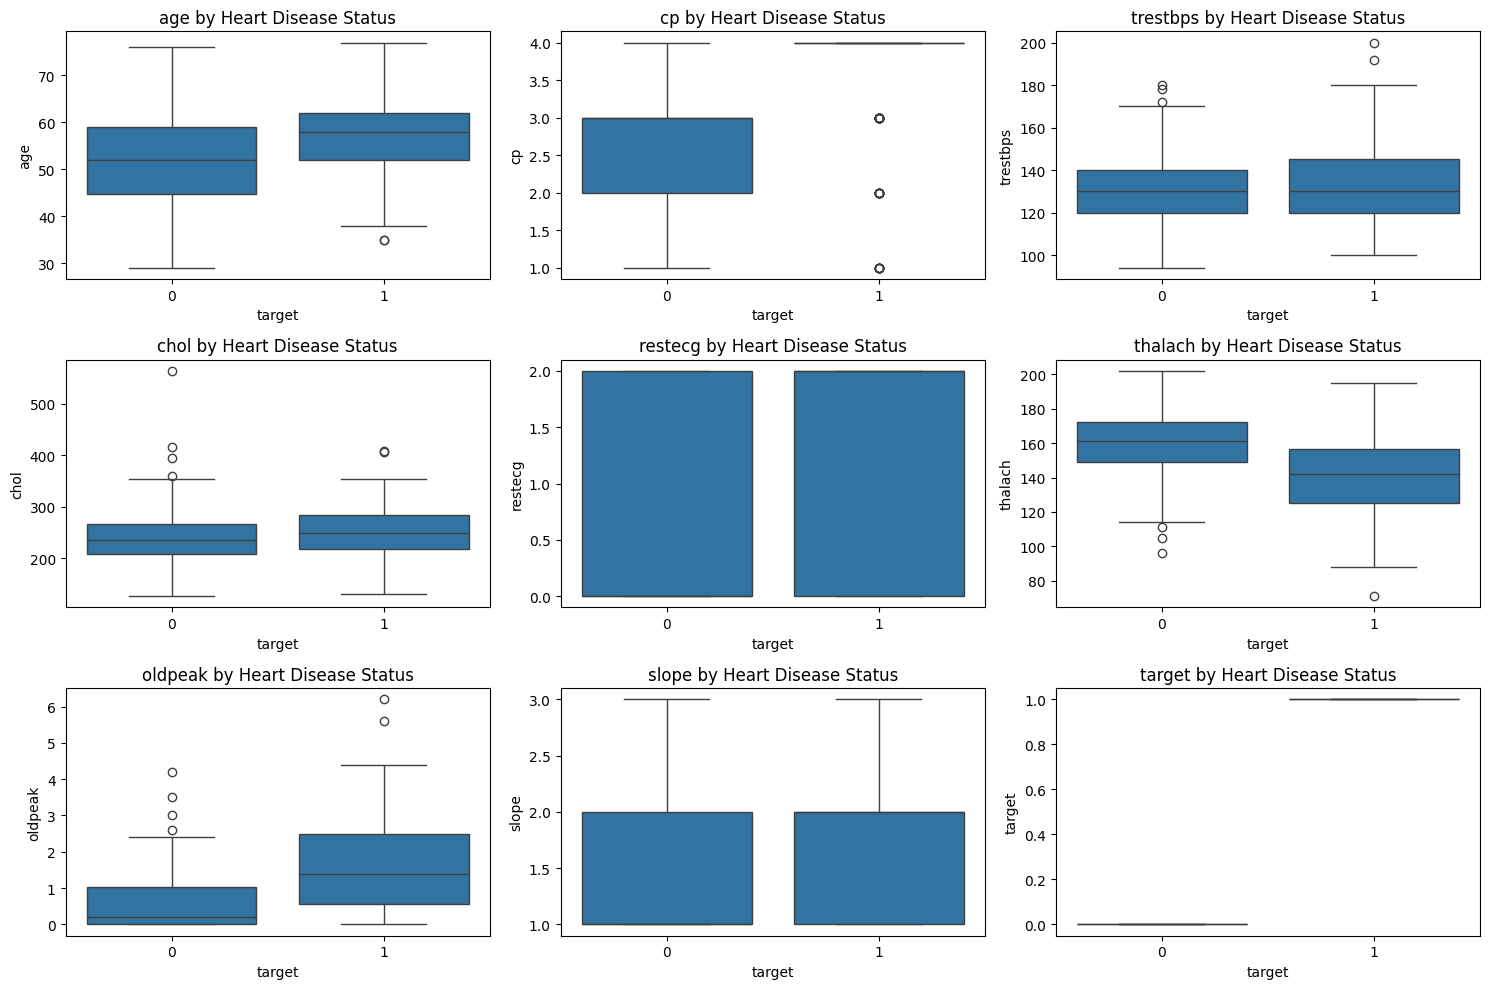

In [11]:
plt.figure(figsize=(15, 10))
subplot_count = 0
for feature in numerical_features:
    if feature != 'sex' and feature != 'fbs' and feature != 'exang':
        subplot_count += 1
        plt.subplot(3, 3, subplot_count)
        sns.boxplot(data=data, x='target', y=feature)
        plt.title(f'{feature} by Heart Disease Status')
plt.tight_layout()
plt.show()

In [12]:
profile = pp.ProfileReport(data, title="Heart Disease Dataset Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:00<00:00, 242.51it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
data.replace('?', "NA", inplace=True)

## 3) Pré-processamento de Dados

In [14]:
missing_values = data.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])

data['ca'] = pd.to_numeric(data['ca'], errors='coerce')
data['ca'].fillna(data['ca'].median(), inplace=True)

data['thal'].fillna(data['thal'].mode()[0], inplace=True)

print("\nMissing values after imputation:")
print(data.isnull().sum().sum())

Missing values in each column:
Series([], dtype: int64)

Missing values after imputation:
0


C:\Users\CCassolF\AppData\Local\Temp\ipykernel_37540\2225969602.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['ca'].fillna(data['ca'].median(), inplace=True)
C:\Users\CCassolF\AppData\Local\Temp\ipykernel_37540\2225969602.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

### Limpeza de Dados

Converta variáveis ​​categóricas em formato numérico para modelos de aprendizado de máquina.

In [15]:
categorical_cols = data.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_cols.tolist())

data_encoded = pd.get_dummies(data, columns=['cp', 'thal'], drop_first=True)

data_encoded['target'] = (data_encoded['target'] > 0).astype(int)

print("\nShape after encoding:", data_encoded.shape)
print("\nEncoded columns:", data_encoded.columns.tolist())

data_encoded = data_encoded.dropna(subset=['target'])

Categorical columns: ['thal']

Shape after encoding: (303, 18)

Encoded columns: ['age', 'sex', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'target', 'cp_2.0', 'cp_3.0', 'cp_4.0', 'thal_6.0', 'thal_7.0', 'thal_NA']


### Normalização de Dados

Padronize características numéricas para que média = 0 e desvio padrão = 1.

In [16]:
numerical_features_to_scale = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']

scaler = StandardScaler()

data_encoded[numerical_features_to_scale] = scaler.fit_transform(data_encoded[numerical_features_to_scale])

data_encoded[numerical_features_to_scale].describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,-1.465641e-18,1.001654,-2.819115,-0.713556,0.172994,0.727089,2.500191
trestbps,303.0,4.426236e-16,1.001654,-2.145037,-0.665300,-0.096170,0.472960,3.887739
chol,303.0,2.345026e-16,1.001654,-2.334877,-0.690503,-0.110136,0.547614,6.138485
thalach,303.0,-1.172513e-16,1.001654,-3.442067,-0.705307,0.148562,0.717808,2.294182
oldpeak,303.0,2.345026e-17,1.001654,-0.896862,-0.896862,-0.206705,0.483451,4.451851
ca,303.0,-4.690051e-17,1.001654,-0.711131,-0.711131,-0.711131,0.360873,2.504881


### Engenharia de Features

Cria novos recursos que possam ser úteis para previsão.

In [17]:
data_encoded['AgeGroup'] = pd.cut(data['age'], bins=[0, 40, 55, 65, 100], 
labels=['Young', 'Middle-aged', 'Senior', 'Elderly'])

data_encoded = pd.get_dummies(data_encoded, columns=['AgeGroup'], drop_first=True)

data_encoded['BP_per_Age'] = data['trestbps'] / data['age']
data_encoded['HR_per_Age'] = data['thalach'] / data['age']

print("Dataset shape after feature engineering:", data_encoded.shape)
data_encoded.head()

Dataset shape after feature engineering: (303, 23)


,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,...,cp_3.0,cp_4.0,thal_6.0,thal_7.0,thal_NA,AgeGroup_Middle-aged,AgeGroup_Senior,AgeGroup_Elderly,BP_per_Age,HR_per_Age
0,0.948726,1.0,0.757525,-0.264900,1.0,2.0,0.017197,0.0,1.087338,3.0,...,False,False,True,False,False,False,True,False,2.301587,2.380952
1,1.392002,1.0,1.611220,0.760415,0.0,2.0,-1.821905,1.0,0.397182,2.0,...,False,True,False,False,False,False,False,True,2.388060,1.611940
2,1.392002,1.0,-0.665300,-0.342283,0.0,2.0,-0.902354,1.0,1.346147,2.0,...,False,True,False,True,False,False,False,True,1.791045,1.925373
3,-1.932564,1.0,-0.096170,0.063974,0.0,0.0,1.637359,0.0,2.122573,3.0,...,True,False,False,False,False,False,False,False,3.513514,5.054054
4,-1.489288,0.0,-0.096170,-0.825922,0.0,2.0,0.980537,0.0,0.310912,1.0,...,False,False,False,False,False,True,False,False,3.170732,4.195122


### Divisão de Dados

Divide o conjunto de dados em conjuntos de treinamento e teste.

In [18]:
X = data_encoded.drop('target', axis=1)
y = data_encoded['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))
print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True))

X_train shape: (242, 22)
X_test shape: (61, 22)
y_train shape: (242,)
y_test shape: (61,)

Class distribution in training set:
target
0    0.541322
1    0.458678
Name: proportion, dtype: float64

Class distribution in test set:
target
0    0.540984
1    0.459016
Name: proportion, dtype: float64


### Aumento de Dados

Implementa técnicas de aumento de dados para lidar com desequilíbrio de classes, se necessário.

In [19]:
class_counts = y_train.value_counts()
print("Class distribution before augmentation:")
print(class_counts)

if abs(class_counts[0] - class_counts[1]) / len(y_train) > 0.2:  # If imbalance exceeds 20%
    from imblearn.over_sampling import SMOTE
    
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    print("\nClass distribution after SMOTE:")
    print(pd.Series(y_train_resampled).value_counts())
    
    X_train = X_train_resampled
    y_train = y_train_resampled
    
    print(f"\nNew X_train shape: {X_train.shape}")
else:
    print("\nNo significant class imbalance detected. Skipping augmentation.")

Class distribution before augmentation:
target
0    131
1    111
Name: count, dtype: int64

No significant class imbalance detected. Skipping augmentation.


## 4) Seleção do Modelo

Nesta seção, construiremos e avaliaremos múltiplos modelos de aprendizado de máquina para predição de doenças cardíacas:
1. Treinar modelos usando validação cruzada
2. Comparar o desempenho dos modelos
3. Ajustar os hiperparâmetros dos melhores modelos
4. Avaliar o desempenho final do modelo

### Treinamento de Modelos (usando validação cruzada)

Treinaremos vários modelos de classificação usando validação cruzada k-fold para obter uma estimativa confiável de seu desempenho.

In [20]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42),
    'Naive Bayes': GaussianNB(),
    'XGBoost': XGBClassifier(random_state=42)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {}

for name, model in models.items():
    cv_accuracy = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    cv_roc_auc = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    cv_f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')

    cv_results[name] = {
        'Accuracy': cv_accuracy,
        'ROC-AUC': cv_roc_auc,
        'F1 Score': cv_f1
    }
    
    print(f"Model: {name}")
    print(f"Mean Accuracy: {cv_accuracy.mean():.4f} (±{cv_accuracy.std():.4f})")
    print(f"Mean ROC-AUC: {cv_roc_auc.mean():.4f} (±{cv_roc_auc.std():.4f})")
    print(f"Mean F1 Score: {cv_f1.mean():.4f} (±{cv_f1.std():.4f})")
    print('-'*50)

Model: Logistic Regression
Mean Accuracy: 0.8263 (±0.0224)
Mean ROC-AUC: 0.9058 (±0.0227)
Mean F1 Score: 0.8023 (±0.0181)
--------------------------------------------------
Model: Random Forest
Mean Accuracy: 0.8222 (±0.0313)
Mean ROC-AUC: 0.8961 (±0.0286)
Mean F1 Score: 0.7968 (±0.0469)
--------------------------------------------------


c:\Users\CCassolF\www\unijui\TCC\CardioCheckAI\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] O sistema não pode encontrar o arquivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\CCassolF\www\unijui\TCC\CardioCheckAI\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Python312\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht

Model: K-Nearest Neighbors
Mean Accuracy: 0.8099 (±0.0400)
Mean ROC-AUC: 0.8672 (±0.0329)
Mean F1 Score: 0.7884 (±0.0440)
--------------------------------------------------
Model: Decision Tree
Mean Accuracy: 0.7360 (±0.0538)
Mean ROC-AUC: 0.7329 (±0.0537)
Mean F1 Score: 0.7089 (±0.0605)
--------------------------------------------------
Model: Support Vector Machine
Mean Accuracy: 0.8264 (±0.0174)
Mean ROC-AUC: 0.8942 (±0.0147)
Mean F1 Score: 0.7911 (±0.0246)
--------------------------------------------------
Model: Naive Bayes
Mean Accuracy: 0.7235 (±0.0331)
Mean ROC-AUC: 0.8603 (±0.0436)
Mean F1 Score: 0.6141 (±0.0951)
--------------------------------------------------
Model: XGBoost
Mean Accuracy: 0.7811 (±0.0270)
Mean ROC-AUC: 0.8675 (±0.0200)
Mean F1 Score: 0.7581 (±0.0397)
--------------------------------------------------


### Comparação de Modelos

Vamos comparar o desempenho de diferentes modelos com base nos resultados da validação cruzada.

In [21]:
cv_accuracy_df = pd.DataFrame({name: results['Accuracy'] for name, results in cv_results.items()})
cv_roc_auc_df = pd.DataFrame({name: results['ROC-AUC'] for name, results in cv_results.items()})
cv_f1_df = pd.DataFrame({name: results['F1 Score'] for name, results in cv_results.items()})

cv_means = pd.DataFrame({
    'Mean Accuracy': cv_accuracy_df.mean(),
    'Mean ROC-AUC': cv_roc_auc_df.mean(),
    'Mean F1 Score': cv_f1_df.mean()
}).sort_values(by='Mean ROC-AUC', ascending=False)

cv_std = pd.DataFrame({
    'Std Accuracy': cv_accuracy_df.std(),
    'Std ROC-AUC': cv_roc_auc_df.std(),
    'Std F1 Score': cv_f1_df.std()
})

print("Models ranked by ROC-AUC score:")
print(cv_means)

Models ranked by ROC-AUC score:
                        Mean Accuracy  Mean ROC-AUC  Mean F1 Score
Logistic Regression          0.826276      0.905759       0.802329
Random Forest                0.822194      0.896148       0.796776
Support Vector Machine       0.826361      0.894249       0.791097
XGBoost                      0.781122      0.867480       0.758149
K-Nearest Neighbors          0.809949      0.867186       0.788379
Naive Bayes                  0.723469      0.860300       0.614133
Decision Tree                0.735969      0.732897       0.708946


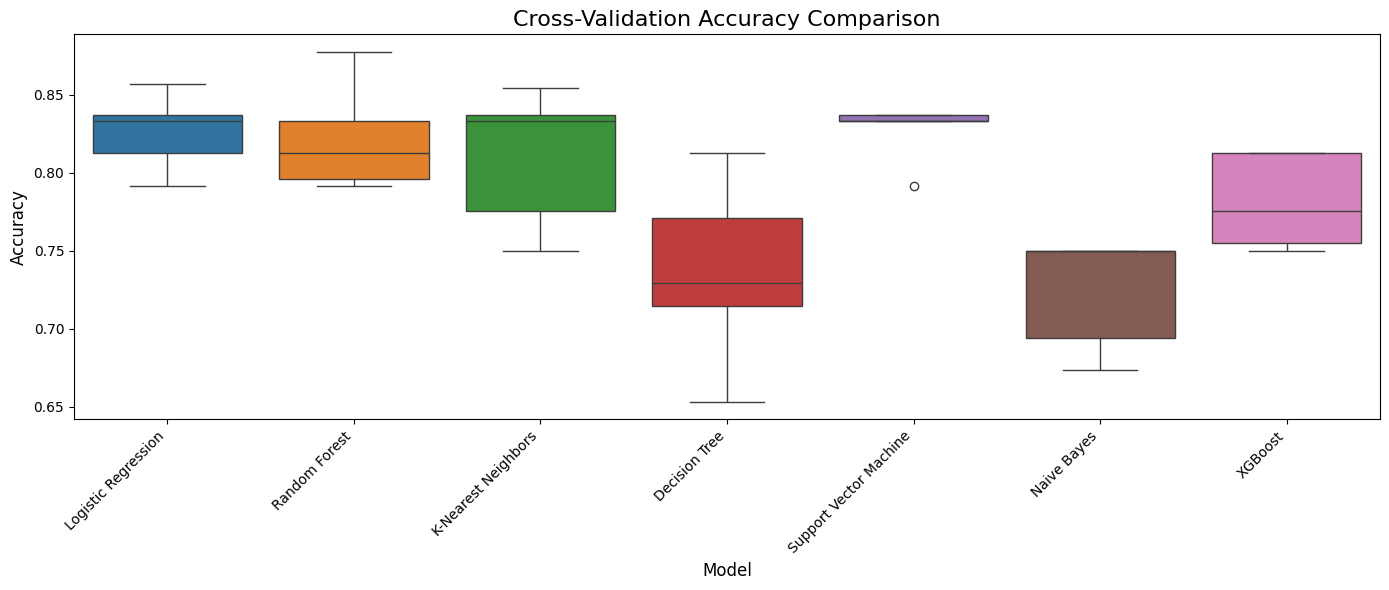

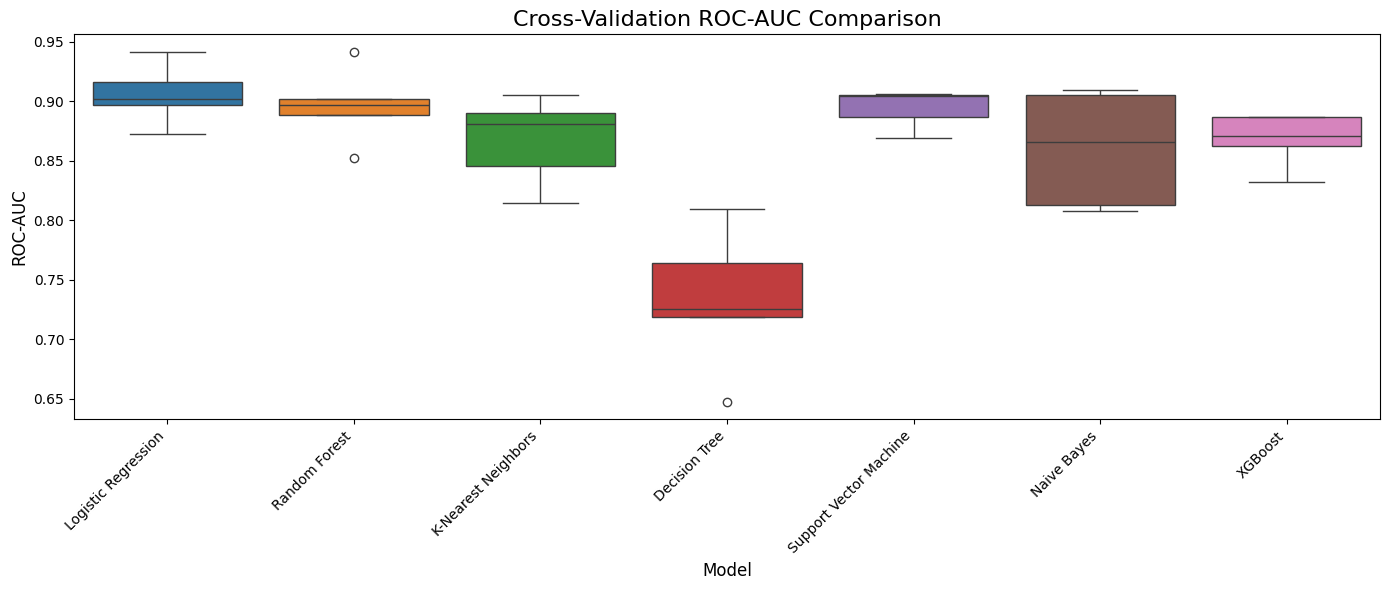

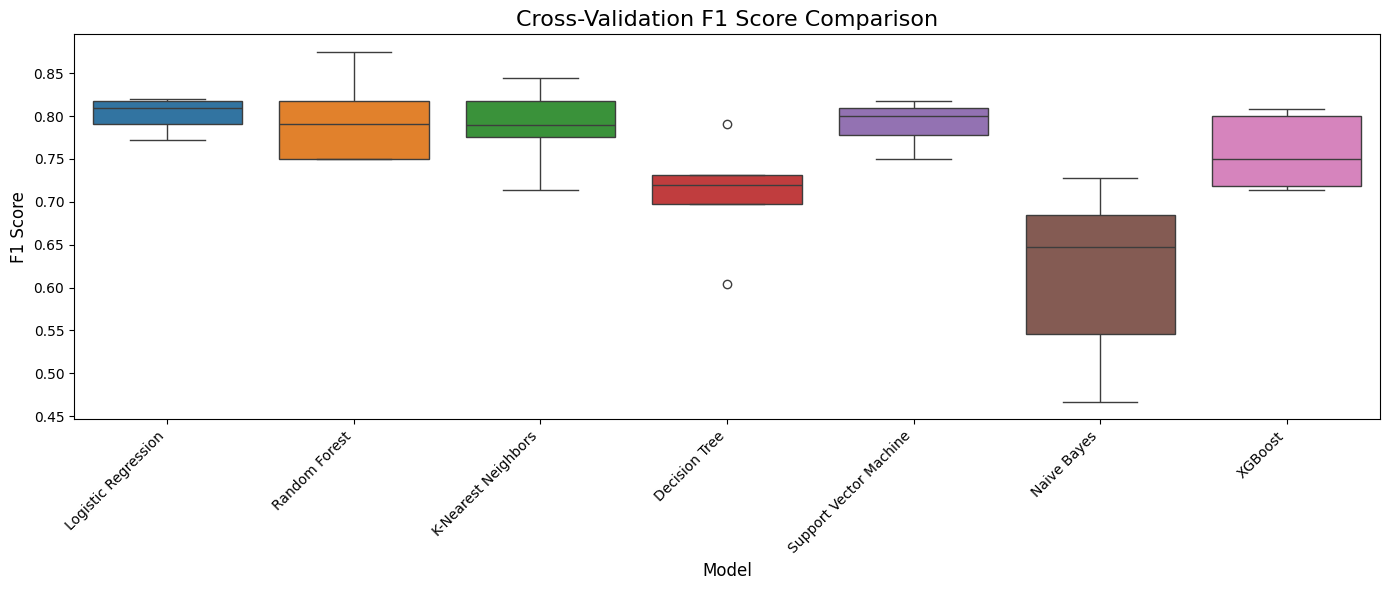

In [22]:
plt.figure(figsize=(14, 6))
ax = sns.boxplot(data=cv_accuracy_df)
ax.set_title('Cross-Validation Accuracy Comparison', fontsize=16)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
ax = sns.boxplot(data=cv_roc_auc_df)
ax.set_title('Cross-Validation ROC-AUC Comparison', fontsize=16)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('ROC-AUC', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
ax = sns.boxplot(data=cv_f1_df)
ax.set_title('Cross-Validation F1 Score Comparison', fontsize=16)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Otimização de Hiperparâmetros

Vamos selecionar os modelos de melhor desempenho da nossa comparação e otimizar seus hiperparâmetros usando a Pesquisa em Grade ou a Pesquisa Aleatória com um espaço de parâmetros simplificado para evitar problemas de memória.

In [23]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score

print("Tuning XGBoost hyperparameters...")
xgb_param_grid = {
    'learning_rate': [0.1],
    'max_depth': [3, 5],
    'n_estimators': [100]
}

try:
    xgb_random = RandomizedSearchCV(
        estimator=XGBClassifier(random_state=42),
        param_distributions=xgb_param_grid,
        n_iter=2,
        scoring='roc_auc',
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=1
    )

    xgb_random.fit(X_train, y_train)

    print(f"Best parameters: {xgb_random.best_params_}")
    print(f"Best score: {xgb_random.best_score_:.4f}")
    print("-"*50)

    best_xgb = xgb_random.best_estimator_
    
except Exception as e:
    print(f"Error during XGBoost tuning: {e}")
    print("Using default XGBoost model instead")
    best_xgb = XGBClassifier(
        random_state=42,
        learning_rate=0.1,
        max_depth=3,
        n_estimators=100
    )
    best_xgb.fit(X_train, y_train)

Tuning XGBoost hyperparameters...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
Best score: 0.8778
--------------------------------------------------


In [24]:
print("Tuning Random Forest hyperparameters...")
rf_param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 10],
    'min_samples_split': [2]
}

try:
    rf_random = RandomizedSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_distributions=rf_param_grid,
        n_iter=2,
        scoring='roc_auc',
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=1
    )

    rf_random.fit(X_train, y_train)

    print(f"Best parameters: {rf_random.best_params_}")
    print(f"Best score: {rf_random.best_score_:.4f}")
    print("-"*50)

    best_rf = rf_random.best_estimator_
    
except Exception as e:
    print(f"Error during Random Forest tuning: {e}")
    print("Using default Random Forest model instead")
    best_rf = RandomForestClassifier(
        random_state=42,
        n_estimators=100
    )
    best_rf.fit(X_train, y_train)

Tuning Random Forest hyperparameters...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': None}
Best score: 0.8850
--------------------------------------------------


In [25]:
print("Tuning Logistic Regression hyperparameters...")

lr_param_grid = [
    {'penalty': ['l2'], 'C': [0.1, 1, 10], 'solver': ['lbfgs'], 'max_iter': [1000]},
    {'penalty': ['none'], 'solver': ['lbfgs'], 'max_iter': [1000]}
]

try:
    lr_random = RandomizedSearchCV(
        estimator=LogisticRegression(random_state=42),
        param_distributions=lr_param_grid,
        n_iter=2,
        scoring='roc_auc',
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=1
    )

    lr_random.fit(X_train, y_train)

    print(f"Best parameters: {lr_random.best_params_}")
    print(f"Best score: {lr_random.best_score_:.4f}")
    print("-"*50)

    best_lr = lr_random.best_estimator_
    
except Exception as e:
    print(f"Error during Logistic Regression tuning: {e}")
    print("Using default Logistic Regression model instead")
    best_lr = LogisticRegression(
        random_state=42,
        max_iter=1000
    )
    best_lr.fit(X_train, y_train)

Tuning Logistic Regression hyperparameters...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 1000, 'C': 1}
Best score: 0.8980
--------------------------------------------------


c:\Users\CCassolF\www\unijui\TCC\CardioCheckAI\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
3 fits failed out of a total of 6.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\CCassolF\www\unijui\TCC\CardioCheckAI\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\CCassolF\www\unijui\TCC\CardioCheckAI\.venv\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\CCassolF\www\unijui\TCC\CardioCheckAI\.venv\Lib\site-packages\sklearn\base.py", line 666

### Avaliação do Modelo

Agora, vamos avaliar nossos modelos ajustados no conjunto de testes para avaliar seu desempenho.

In [26]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

print("Evaluating the best models on the test set...")

xgb_eval = evaluate_model(best_xgb, X_test, y_test)
print("XGBoost Performance:")
print(f"Accuracy: {xgb_eval['accuracy']:.4f}")
print(f"Precision: {xgb_eval['precision']:.4f}")
print(f"Recall: {xgb_eval['recall']:.4f}")
print(f"F1 Score: {xgb_eval['f1_score']:.4f}")
print(f"ROC-AUC: {xgb_eval['roc_auc']:.4f}")
print("Confusion Matrix:")
print(xgb_eval['confusion_matrix'])
print("-"*50)

rf_eval = evaluate_model(best_rf, X_test, y_test)
print("Random Forest Performance:")
print(f"Accuracy: {rf_eval['accuracy']:.4f}")
print(f"Precision: {rf_eval['precision']:.4f}")
print(f"Recall: {rf_eval['recall']:.4f}")
print(f"F1 Score: {rf_eval['f1_score']:.4f}")
print(f"ROC-AUC: {rf_eval['roc_auc']:.4f}")
print("Confusion Matrix:")
print(rf_eval['confusion_matrix'])
print("-"*50)

lr_eval = evaluate_model(best_lr, X_test, y_test)
print("Logistic Regression Performance:")
print(f"Accuracy: {lr_eval['accuracy']:.4f}")
print(f"Precision: {lr_eval['precision']:.4f}")
print(f"Recall: {lr_eval['recall']:.4f}")
print(f"F1 Score: {lr_eval['f1_score']:.4f}")
print(f"ROC-AUC: {lr_eval['roc_auc']:.4f}")
print("Confusion Matrix:")
print(lr_eval['confusion_matrix'])
print("-"*50)

Evaluating the best models on the test set...
XGBoost Performance:
Accuracy: 0.9016
Precision: 0.8667
Recall: 0.9286
F1 Score: 0.8966
ROC-AUC: 0.9459
Confusion Matrix:
[[29  4]
 [ 2 26]]
--------------------------------------------------
Random Forest Performance:
Accuracy: 0.9180
Precision: 0.8710
Recall: 0.9643
F1 Score: 0.9153
ROC-AUC: 0.9589
Confusion Matrix:
[[29  4]
 [ 1 27]]
--------------------------------------------------
Logistic Regression Performance:
Accuracy: 0.9016
Precision: 0.8667
Recall: 0.9286
F1 Score: 0.8966
ROC-AUC: 0.9621
Confusion Matrix:
[[29  4]
 [ 2 26]]
--------------------------------------------------


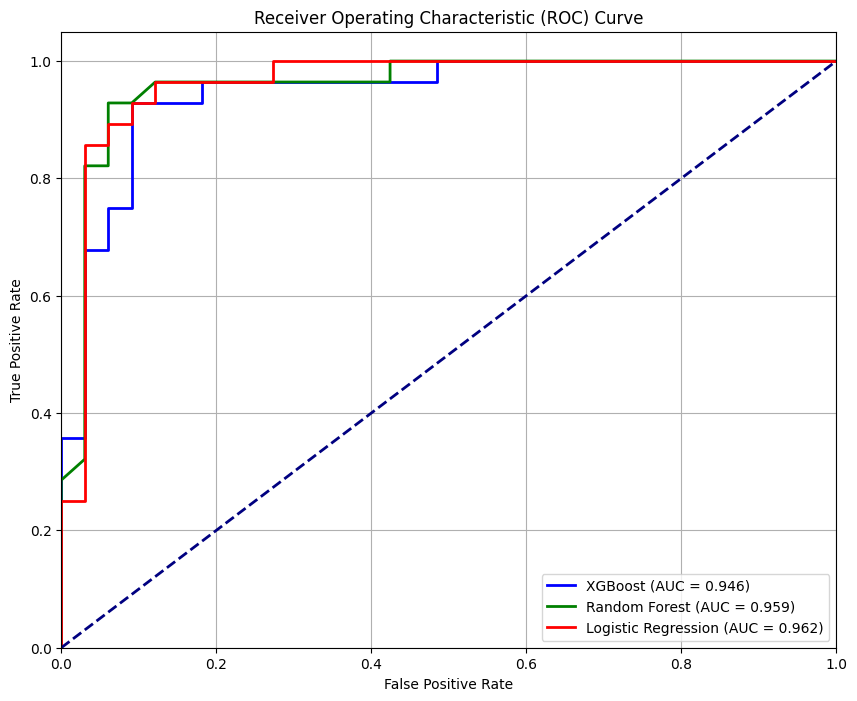

In [27]:
plt.figure(figsize=(10, 8))

models_eval = [
    ('XGBoost', xgb_eval, 'blue'),
    ('Random Forest', rf_eval, 'green'),
    ('Logistic Regression', lr_eval, 'red')
]

for name, eval_results, color in models_eval:
    fpr, tpr, _ = roc_curve(y_test, eval_results['y_pred_proba'])
    roc_auc = eval_results['roc_auc']
    
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

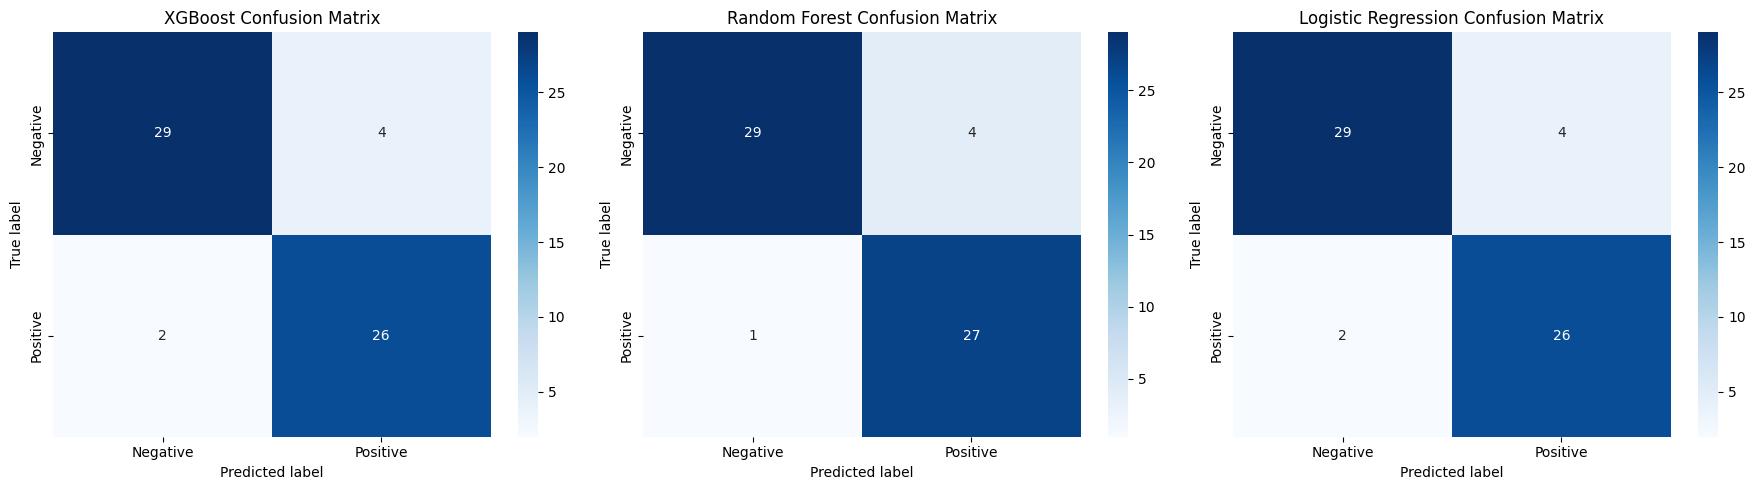

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_eval = [
    ('XGBoost', xgb_eval, axes[0]),
    ('Random Forest', rf_eval, axes[1]),
    ('Logistic Regression', lr_eval, axes[2])
]

for name, eval_results, ax in models_eval:
    cm = eval_results['confusion_matrix']
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title(f'{name} Confusion Matrix')
    ax.set_xticklabels(['Negative', 'Positive'])
    ax.set_yticklabels(['Negative', 'Positive'])

plt.tight_layout()
plt.show()

Model Comparison Summary:
            XGBoost  Random Forest  Logistic Regression
Accuracy   0.901639       0.918033             0.901639
Precision  0.866667       0.870968             0.866667
Recall     0.928571       0.964286             0.928571
F1 Score   0.896552       0.915254             0.896552
ROC-AUC    0.945887       0.958874             0.962121


<Figure size 1200x800 with 0 Axes>

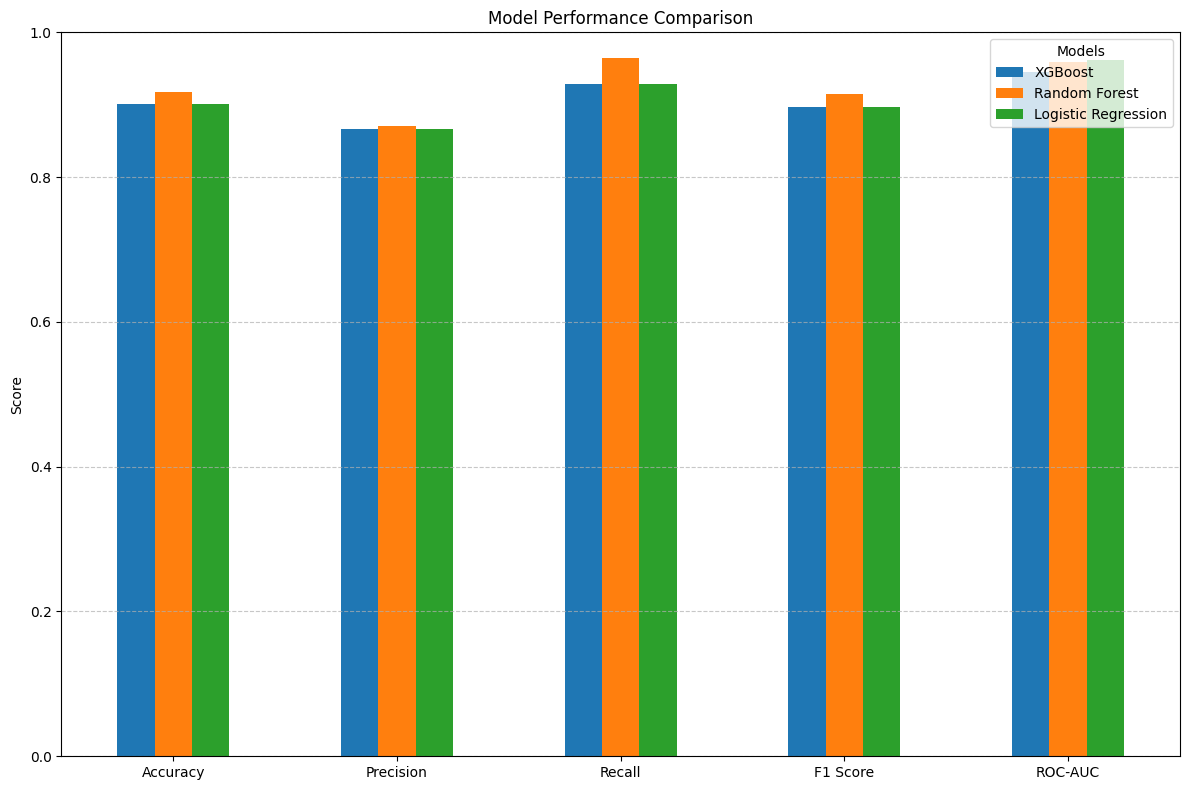

In [29]:
model_comparison = pd.DataFrame({
    'XGBoost': [
        xgb_eval['accuracy'],
        xgb_eval['precision'],
        xgb_eval['recall'],
        xgb_eval['f1_score'],
        xgb_eval['roc_auc']
    ],
    'Random Forest': [
        rf_eval['accuracy'],
        rf_eval['precision'],
        rf_eval['recall'],
        rf_eval['f1_score'],
        rf_eval['roc_auc']
    ],
    'Logistic Regression': [
        lr_eval['accuracy'],
        lr_eval['precision'],
        lr_eval['recall'],
        lr_eval['f1_score'],
        lr_eval['roc_auc']
    ]
}, index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC'])

print("Model Comparison Summary:")
print(model_comparison)

plt.figure(figsize=(12, 8))
model_comparison.plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Models')
plt.tight_layout()
plt.show()

### Análise de Importância de Recursos

Vamos analisar quais características contribuem mais para as previsões do nosso melhor modelo.

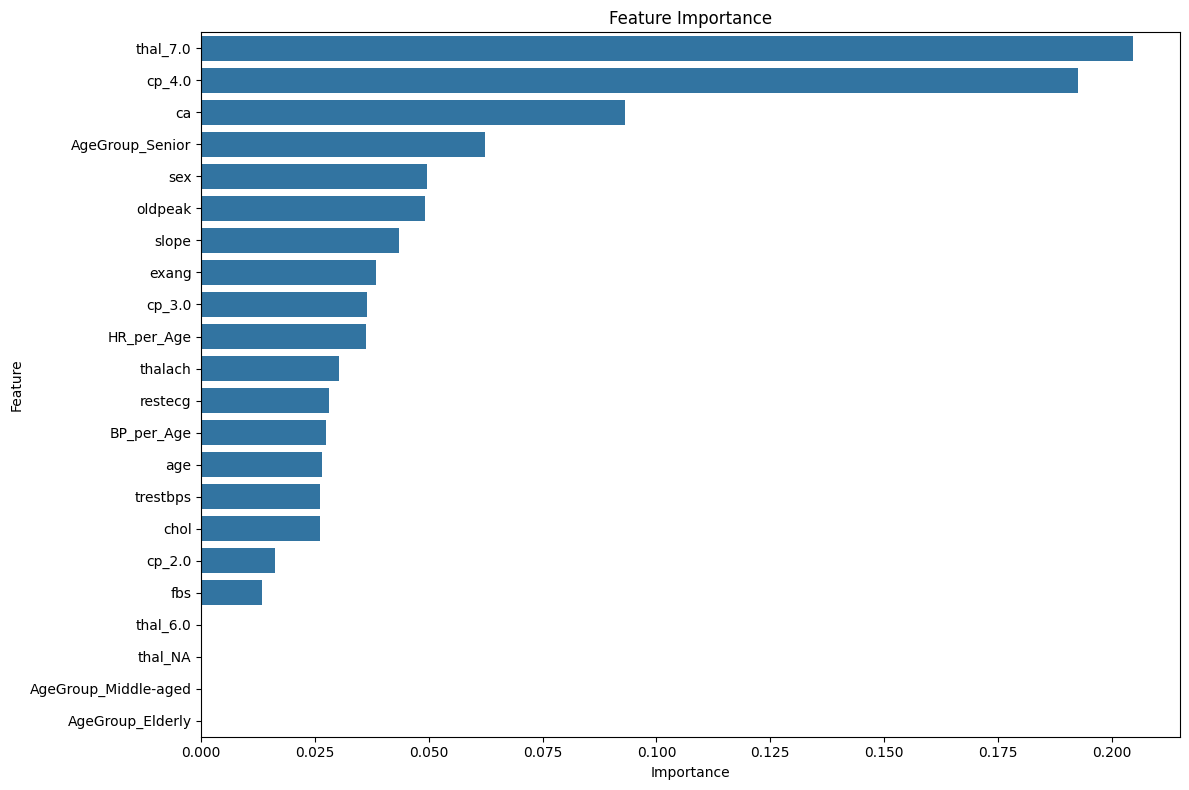

In [30]:
best_model = best_xgb

if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()
    
elif hasattr(best_model, 'coef_'):
    coefficients = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': best_model.coef_[0]
    }).sort_values(by='Coefficient', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Coefficient', y='Feature', data=coefficients)
    plt.title('Feature Coefficients')
    plt.tight_layout()
    plt.show()
else:
    print("Feature importance not available for this model.")

## 5) Salvamento do Melhor Modelo

Vamos salvar nosso modelo de melhor desempenho em disco para que ele possa ser usado em produção ou compartilhado com outros.

In [31]:
import joblib
import os

model_performances = {
    'Logistic Regression': lr_eval['roc_auc'],
    'Random Forest': rf_eval['roc_auc'],
    'XGBoost': xgb_eval['roc_auc']
}

best_model_name = max(model_performances, key=model_performances.get)
print(f"The best performing model is: {best_model_name} with ROC-AUC: {model_performances[best_model_name]:.4f}")

model_objects = {
    'Logistic Regression': best_lr,
    'Random Forest': best_rf,
    'XGBoost': best_xgb
}

best_model = model_objects[best_model_name]

save_dir = 'saved_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

model_filename = os.path.join(save_dir, f'{best_model_name.replace(" ", "_").lower()}_model.joblib')
joblib.dump(best_model, model_filename)

scaler_filename = os.path.join(save_dir, 'scaler.joblib')
joblib.dump(scaler, scaler_filename)

preprocessing_info = {
    'numerical_features_to_scale': numerical_features_to_scale,
    'feature_names': list(X.columns)
}
preprocessing_filename = os.path.join(save_dir, 'preprocessing_info.joblib')
joblib.dump(preprocessing_info, preprocessing_filename)

print(f"Model saved to {model_filename}")
print(f"Scaler saved to {scaler_filename}")
print(f"Preprocessing info saved to {preprocessing_filename}")

The best performing model is: Logistic Regression with ROC-AUC: 0.9621
Model saved to saved_models\logistic_regression_model.joblib
Scaler saved to saved_models\scaler.joblib
Preprocessing info saved to saved_models\preprocessing_info.joblib


In [32]:
loaded_model = joblib.load(model_filename)
loaded_scaler = joblib.load(scaler_filename)
loaded_preprocessing_info = joblib.load(preprocessing_filename)

sample_index = 0
sample_X = X_test.iloc[[sample_index]]
sample_y = y_test.iloc[sample_index]

sample_pred = loaded_model.predict(sample_X)[0]
sample_pred_proba = loaded_model.predict_proba(sample_X)[0, 1]

print(f"Sample features: {sample_X.values[0]}")
print(f"True label: {'Heart Disease' if sample_y == 1 else 'No Heart Disease'}")
print(f"Predicted label: {'Heart Disease' if sample_pred == 1 else 'No Heart Disease'}")
print(f"Predicted probability of Heart Disease: {sample_pred_proba:.4f}")

Sample features: [0.5054510345141467 1.0 0.35913411307650606 0.47023155978413295 0.0 2.0
 1.4184183897788027 0.0 -0.8968617158532323 1.0 -0.7111313860964096 False
 False True False False False False True False 2.3389830508474576
 3.0847457627118646]
True label: No Heart Disease
Predicted label: No Heart Disease
Predicted probability of Heart Disease: 0.3328
